In [1]:
# imports
import collections
import itertools
import random
import math

import boruta
import IPython
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pyteomics import electrochem, mass, parser
from skbio.diversity.alpha import shannon
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing

%matplotlib inline

pd.options.display.max_rows = 10
pd.options.display.precision = 3
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['xtick.labelsize'] = 6

## Functions

## Reading and parsing input data

**TODO Nicolas:** write something about the origin of both data sets.

In [2]:
def split_rows(df, column_name, split_str):
    """
    Duplicates and splits rows in a pandas `DataFrame` based on the given split substring.
    
    Rows that contain the given split substring in the given column will be duplicated with each new row
    containing part of the split column in the corresponding column.
    
    Args:
        - df: The pandas `DataFrame` in which rows will be duplicated and split.
        - column_name: The name of the column in the given `DataFrame` on which rows will be duplicated and split.
        - split_str: The substring on which the column with the given name in the given `DataFrame` will be split.
        
    Returns:
        (A copy of) the `DataFrame` in which rows containing the given split substring in the given column are
        duplicated and split.
    """
    # split the indicated column on the given split substring
    split_column = df[column_name].str.split(split_str, expand=True).stack()
    # create a new dataframe with each of the split rows duplicated
    i = split_column.index.get_level_values(0)
    df2 = df.loc[i].copy().reset_index(drop=True)
    # assign the split substring to the indicated column
    df2[column_name] = split_column.values
    return df2


def gene_to_family(gene):
    """
    Reduce a (potentially compound) gene name to its family level.
    
    Args:
        - gene: A gene name. This can either consist of only a family name (single numeric format), a compound
                name of family and gene (numeric dash numeric format), or 'unresolved'.
                
    Returns:
        A string of length 2 containing the gene family name (optionally prepended with a 0), or 'unresolved'.
    """    
    gene_str = str(gene)
    if gene_str == 'unresolved':
        return gene_string
    else:
        return gene_str.split('-')[0].zfill(2)


def encode_gene(gene):
    """
    Uniformly encode genes as strings of length 2.
    
    If both the family and the gene name are known these are separated by a dash.
    
    Args:
        - gene: A gene name. This can either consist of only a family name (single numeric format), a compound
                name of family and gene (numeric dash numeric format), or 'unresolved'.

    Returns:
        The family and gene name as a string of length 2 separated by a dash if both are known, otherwise
        only the family name as a string of length 2, or 'unresolved'.
    """
    gene_str = str(gene)
    if gene_str == 'unresolved':
        return gene_str
    else:
        return '-'.join(g.zfill(2) for g in gene_str.split('-'))

In [3]:
# read peptide data
peptide_data = pd.read_csv('data.csv')

# read control data; splits were already done during processing of immuneaccess data
control_data = pd.read_csv('control_data.csv')

# combine peptide and control data
data = pd.concat([peptide_data, control_data], ignore_index=True)
classes = data['HLA_peptide'].unique()

for gene in [gene for gene in data.columns.values if 'gene' in gene]:
    # split compound gene names (only really applicable to the V gene for the peptide data)
    data = split_rows(data, gene, '/')
    # uniformly encode all gene names
    data[gene] = data[gene].apply(lambda x: encode_gene(x))
    # explicitly add the gene family
    data[gene.replace('gene', 'family')] = data[gene].apply(lambda x: gene_to_family(x))
data = data[sorted(data.columns)]

## Data exploration

In [4]:
def norm_shannon(counts, base=2):
    """
    Calculate the normalized Shannon-Wiener diversity.
    
    The diversity is normalized by dividing the diversity of the given sample counts by the maximum
    diversity for a sample of the same size.
    
    Based on `skbio.diversity.alpha.shannon`.
    
    Args:
        - counts: Vector of counts.
        - base: Logarithm base to use in the calculations.
        
    Returns:
        The normalized Shannon-Wiener diversity.
    """
    reg_shannon = shannon(counts, base)
    max_shannon = shannon(np.ones(sum(counts), np.int8), base)
    
    return reg_shannon / max_shannon


# calculate CDR3 sequence diversity of input data
stats = collections.defaultdict(list)
for peptide in classes:
    pep_data = data[data['HLA_peptide'] == peptide]
    
    stats['total TCRBs'].append(pep_data.shape[0])
    stats['unique CDR3'].append(len(set(pep_data['CDR3_sequence'])))
    
    cdr3_count = list(collections.Counter(pep_data['CDR3_sequence']).values())
    stats['CDR3 diversity'].append(shannon(cdr3_count))
    stats['CDR3 norm diversity'].append(norm_shannon(cdr3_count))
    
    stats['unique V family'].append(len(pep_data['V_family'].unique()))
    stats['unique J family'].append(len(pep_data['J_family'].unique()))
    stats['unique V gene'].append(len(pep_data['V_gene'].unique()))
    stats['unique J gene'].append(len(pep_data['J_gene'].unique()))
    
    v_fam_count = list(collections.Counter(pep_data['V_family']).values())
    j_fam_count = list(collections.Counter(pep_data['J_family']).values())
    v_gene_count = list(collections.Counter(pep_data['V_gene']).values())
    j_gene_count = list(collections.Counter(pep_data['J_gene']).values())
    stats['V family diversity'].append(shannon(v_fam_count))
    stats['J family diversity'].append(shannon(j_fam_count))
    stats['V family norm diversity'].append(norm_shannon(v_fam_count))
    stats['J family norm diversity'].append(norm_shannon(j_fam_count))
    stats['V gene diversity'].append(shannon(v_gene_count))
    stats['J gene diversity'].append(shannon(j_gene_count))
    stats['V gene norm diversity'].append(norm_shannon(v_gene_count))
    stats['J gene norm diversity'].append(norm_shannon(j_gene_count))

IPython.display.display(pd.DataFrame(stats, index=classes, columns=stats.keys()))

,total TCRBs,unique CDR3,CDR3 diversity,CDR3 norm diversity,unique V family,unique J family,unique V gene,unique J gene,V family diversity,J family diversity,V family norm diversity,J family norm diversity,V gene diversity,J gene diversity,V gene norm diversity,J gene norm diversity
EIYKRWII,142,119,6.820,0.954,19,2,33,12,3.653,0.930,0.511,0.130,4.413,3.174,0.617,0.444
FLKEKGGL,95,70,5.916,0.900,18,2,28,12,3.608,0.932,0.549,0.142,4.437,3.175,0.675,0.483
Control,57882,54324,15.672,0.991,27,2,63,14,4.188,0.972,0.265,0.061,5.060,3.154,0.320,0.199


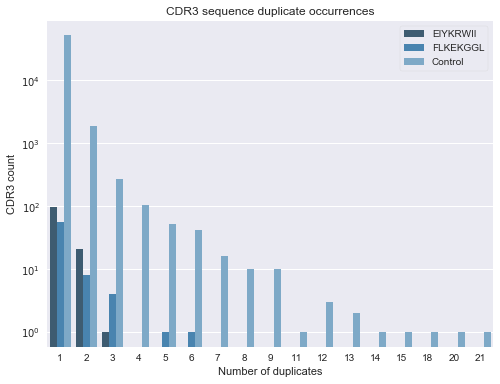

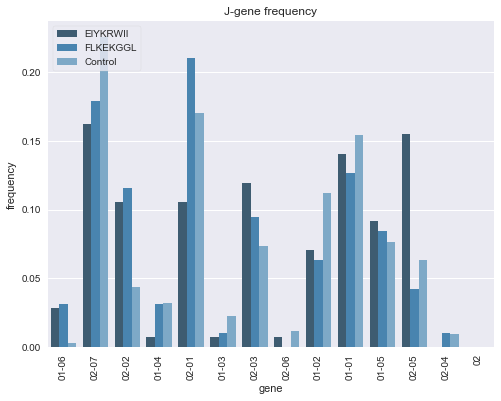

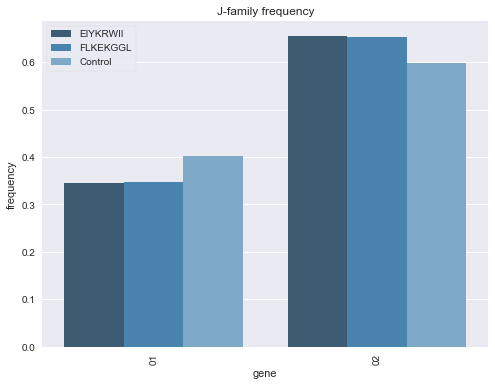

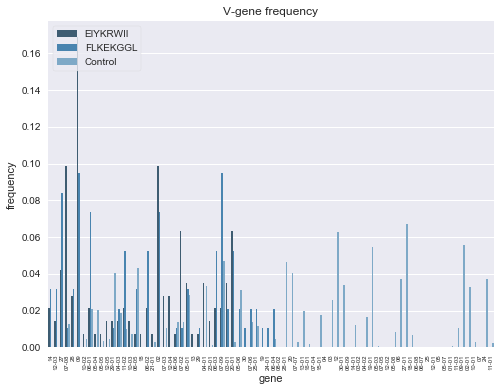

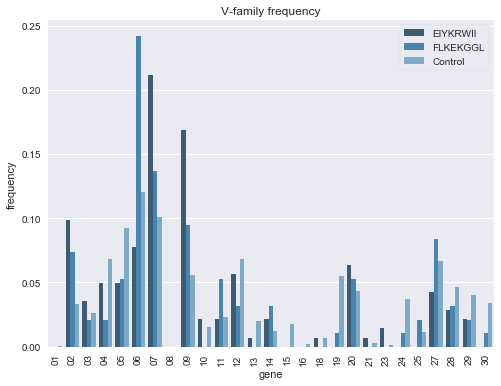

In [8]:
# plot the number of duplicates per CDR3 sequence
counts = []
for peptide in classes:
    count = data[data['HLA_peptide'] == peptide]['CDR3_sequence'].value_counts()
    counts.append(pd.DataFrame({'counts': count, 'peptide': [peptide] * len(count)}))

plt.figure(figsize=(8, 6))

sns.countplot(x='counts', hue='peptide', data=pd.concat(counts), palette='Blues_d')

plt.yscale('log')

plt.title('CDR3 sequence duplicate occurrences')

plt.xlabel('Number of duplicates')
plt.ylabel('CDR3 count')

plt.legend(loc='upper right', frameon=True)

plt.savefig('CDR3sequence_distribution.pdf', bbox_inches='tight', dpi=600)
plt.show()
plt.close()

# show V_gene and J_gene usage at family level
for g in itertools.product([col[0] for col in data.columns.values if 'gene' in col], ['gene', 'family']):
    gene = '_'.join(g)

    if gene == 'V_gene':
        matplotlib.rcParams['xtick.labelsize'] = 6
    else:
        matplotlib.rcParams['xtick.labelsize'] = 10

    gene_freqs = []
    for peptide in classes:
        peptide_counts = data[(data['HLA_peptide'] == peptide) & (data[gene] != 'unresolved')][gene].value_counts(normalize=True, sort=False)
        gene_freqs.append(pd.DataFrame({'gene': peptide_counts.index, 'frequency': peptide_counts.values,
                                        'peptide': [peptide] * len(peptide_counts)}))

    plt.figure(figsize=(8, 6))

    sns.barplot(x='gene', y='frequency', hue='peptide', data=pd.concat(gene_freqs), palette='Blues_d')

    plt.title('{} frequency'.format(gene.replace('_', '-')))
    
    plt.ylabel('frequency')

    plt.xticks(rotation=90)

    plt.legend(loc='best', frameon=True)

    plt.savefig('{}_distribution.pdf'.format(gene), bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()

## Feature generation

For each sequence the following features are generated:
* V- & J-gene and -family occurrence
* Sequence length
* Amino acid count
* Average amino acid physico-chemical properties (basicity, hydrophobicity, helicity, mutational stability)
* Sequence pI
* Position-specific amino acid presence
* Position-specific physico-chemical amino acid properties

In [9]:
# physico-chemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchem_properties = {'basicity': basicity, 'hydrophobicity': hydrophobicity,
                       'helicity': helicity, 'mutation stability': mutation_stability}

In [10]:
def compute_features(data):
    """
    TODO
    """
    features_list = []
    
    # non-positional features (i.e. over the whole sequence)

    # one-hot encode V- and J-genes and -families
    onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
    features_list.append(pd.DataFrame(
        onehot_encoder.fit_transform(data[['V_gene', 'J_gene', 'V_family', 'J_family']].to_dict(orient='records')),
        columns=onehot_encoder.feature_names_))
    
    # sequence length
    features_list.append(data['CDR3_sequence'].apply(lambda sequence: parser.length(sequence)).to_frame()
                         .rename(columns={'CDR3_sequence': 'length'}))

    # number of occurences of each amino acid
    aa_counts = pd.DataFrame.from_records(
        [parser.amino_acid_composition(sequence) for sequence in data['CDR3_sequence']]).fillna(0)
    aa_counts.columns = ['{} count'.format(column) for column in aa_counts.columns]
    features_list.append(aa_counts)

    # average physico-chemical properties
    for prop_name, prop_lookup in physchem_properties.items():
        features_list.append(data['CDR3_sequence'].apply(
            lambda sequence: np.mean(list(prop_lookup[aa] for aa in sequence)))
                               .to_frame().rename(columns={'CDR3_sequence': 'average {}'.format(prop_name)}))
    # pI
    features_list.append(data['CDR3_sequence'].apply(
        lambda sequence: electrochem.pI(sequence)).to_frame().rename(columns={'CDR3_sequence': 'pI'}))
    
    # positional features (i.e. localized at a specific amino acid position)
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_mutation, pos_pI = [[] for _ in range(6)]
    for sequence in data['CDR3_sequence']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1 for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})
        
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})

    features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    
    return pd.concat(features_list, axis=1)

In [11]:
# compute features for each observation
features = compute_features(data)
X = features.values
feature_names = features.columns.values
peptide_encoder = preprocessing.LabelEncoder()
y = peptide_encoder.fit_transform(data['HLA_peptide'])

## Classification

In [25]:
def create_indices(y, pos_label=1, neg_label=0, n_splits=10, test_size=0.1, train_size=None, neg_multiplier=1):
    """
    Yields train and test indices for unbalanced data sets.
    
    Args:
        - y: The class labels.
        - pos_label: Label denoting the positive (small) class.
        - neg_label: Label denoting the negative (large) class.
        - n_splits: Number of splitting iterations.
        - test_size: The proportion of the positive samples to include in the test split.
        - train_size: The proportion of positive samples to include in the train split. If None,
                      the value is automatically set to the complement of the test size.
        - neg_multiplier: Number of times the negative set is larger than the positive set.
        
    Returns:
        A tuple of the training indices and test indices of the current split.
    """
    if train_size is None:
        train_size = 1 - test_size
    
    pos_idx = np.where(y == pos_label)[0]
    neg_idx = np.where(y == neg_label)[0]
    num_pos = len(pos_idx)
    
    pos_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                test_size=int(num_pos * test_size),
                                                train_size=int(num_pos * train_size),
                                                random_state=0)
    neg_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                test_size=int(num_pos * test_size * neg_multiplier),
                                                train_size=int(num_pos * train_size * neg_multiplier),
                                                random_state=0)
    
    for (pos_train_idx, pos_test_idx), (neg_train_idx, neg_test_idx) in\
            zip(pos_splitter.split(pos_idx), neg_splitter.split(neg_idx)):
        yield np.concatenate((pos_idx[pos_train_idx], neg_idx[neg_train_idx])),\
              np.concatenate((pos_idx[pos_test_idx], neg_idx[neg_test_idx]))


def predict(predictor, X, y, train_idx, test_idx):
    """
    Run a single iteration of the predictor.
    
    This is extracted to a method for multithreaded computation using joblib.
    
    Args:
        - predictor: A scikit-learn compatible predictor. The predictor needs to be able to generate probabilities
                     (method `predict_proba`) and export feature importances (attribute `feature_importances_`).
        - X: Input values.
        - y: Target values.
        - train_idx: The indices of the training set.
        - test_idx: The indices of the test set.
        
    Returns:
        A tuple consisting of the target classes, the predicted class probabilities, and the feature importances.
    """    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train the predictor pipeline
        predictor.fit(X_train, y_train)
    
        # extract the relevant feature importances
        importances = np.zeros(X_train.shape[1], float)
        importances[predictor.named_steps['feature_selection'].support_] =\
            predictor.named_steps['classification'].feature_importances_

        # return the predictions to evaluate the performance
        predictions_proba = predictor.predict_proba(X_test)[:, 1]

        # combine the ground truth with the predictions for future reference
        return y_test, predictions_proba, importances

In [26]:
# number of trees in the random forest
n_trees = 200

# create a prediction pipeline consisting of feature selection and classification
# this is an unbalanced classification problem so weight the classes inversely proportional to their frequencies
classifier = ensemble.RandomForestClassifier(n_trees, n_jobs=-1, random_state=0, class_weight='balanced')
feature_selection = boruta.BorutaPy(ensemble.ExtraTreesClassifier(n_jobs=-1), n_estimators='auto', random_state=0)

predictor = pipeline.Pipeline([('feature_selection', feature_selection), ('classification', classifier)])

In [30]:
peptide_predictions = []
for peptide in classes:
    if peptide == 'Control':
        continue
        
    # use 10 times as many negative samples as positive samples in 5 iterations
    index_generator = create_indices(y,
                                     peptide_encoder.transform([peptide])[0],
                                     peptide_encoder.transform(['Control'])[0],
                                     5, 0.2, 0.8, 10)

    result = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(predict)
                                                   (predictor, X, y, train_idx, test_idx)
                                                   for train_idx, test_idx in index_generator))

    predictions = []
    predictions_proba = []
    feature_importances = []
    for y_test, proba, feat in result:
        predictions.append((np.array(y_test != 0, np.int), np.array(proba > 0.5, np.int)))
        predictions_proba.append((np.array(y_test != 0, np.int), proba))
        feature_importances.append(feat)

    peptide_predictions.append((peptide, predictions, predictions_proba, feature_importances))

EIYKRWII
Classification accuracy = 95.58% ± 0.89%


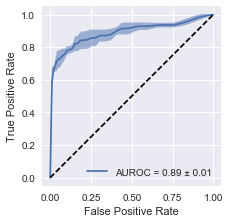

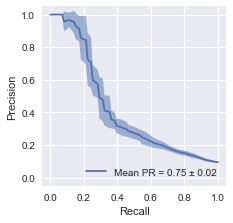

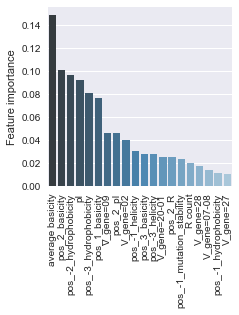

FLKEKGGL
Classification accuracy = 94.35% ± 0.56%


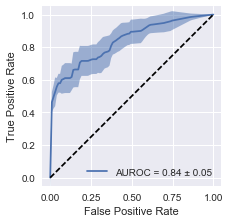

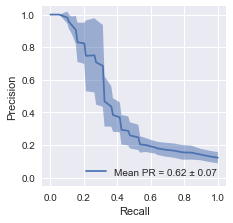

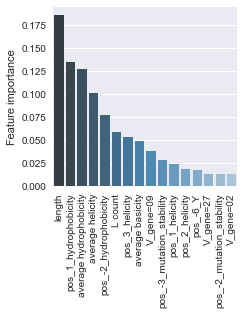

In [35]:
for peptide, predictions, predictions_proba, feature_importances in peptide_predictions:
    # evaluate the performance of the prediction pipeline
    # accuracy (although not particularly useful for this unbalanced class problem)
    accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred)
                           for y_test, y_pred in predictions])

    # AUC and average precision
    auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                        for y_test, y_pred in predictions_proba])
    auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                      for y_test, y_pred in predictions_proba])
    avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                                  for y_test, y_pred in predictions_proba])
    avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                                for y_test, y_pred in predictions_proba])
    avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                           for y_test, y_pred in predictions_proba])
    avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                         for y_test, y_pred in predictions_proba])

    # mean and standard deviation of ROC and precision-recall curves
    interval = np.linspace(0, 1, 100)
    tprs, precisions, precisions_inverted = [], [], []
    for y_test, y_pred in predictions_proba:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
        tprs.append(np.interp(interval, fpr, tpr))

        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        precisions.append(np.interp(interval, recall[::-1], precision))

        # inverted precision
        precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
        precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted))

    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
    tpr_std = np.std(tprs, axis=0)
    precision_mean = np.mean(precisions, axis=0)
    precision_std = np.std(precisions, axis=0)
    precision_inverted_mean = np.mean(precisions_inverted, axis=0)
    precision_inverted_std = np.std(precisions_inverted, axis=0)

    # print accuracy
    print(peptide)
    print('Classification accuracy = {:.2%} ± {:.2%}'.format(accuracy_mean, accuracy_std))

    # plot ROC curve
    width, height = 3.3, 3.3

    plt.figure(figsize=(width, height))

    plt.plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
    plt.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc='lower right')

    plt.gca().set_aspect('equal', adjustable='box')

    plt.savefig('AUC_{}_many.pdf'.format(peptide), bbox_inches='tight', dpi=600)

    plt.show()
    plt.close()

    # plot precision-recall curve
    plt.figure(figsize=(width, height))
    plt.plot(interval[::-1], precision_mean,
             label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
    plt.fill_between(interval[::-1], precision_mean - precision_std,
                     precision_mean + precision_std, alpha=0.5)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.legend(loc='lower right')

    plt.savefig('PR_{}_many.pdf'.format(peptide), bbox_inches='tight', dpi=600)

    plt.show()
    plt.close()
    
    # plot feature importances
    feat_import_s = pd.Series(np.mean(feature_importances, axis=0),
                              index=feature_names, name='Feature importances')
    significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)

    plt.figure(figsize=(width, height))

    sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d')

    plt.xticks(rotation='vertical', fontsize=10)
    plt.ylabel('Feature importance')

    plt.savefig('feature_importance_{}_many.pdf'.format(peptide), bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()

## Learning curve

In [ ]:
learning_curve_stats = []
score_method = 'roc_auc'

for peptide, predictions, predictions_proba, feature_importances in peptide_predictions:
    # compute the learning curve
    #selected_features = np.mean(feature_importances, axis=0) > 0.01
    #X_filtered = X_features[[X_features.columns[i] for i in range(len(X_features.columns))\
    #                         if selected_features[i] == True]]
    X_filtered = X_features.iloc[y[(y==peptide)|(y==negative)].index].reset_index(drop=True).values
    y_filtered = y[(y==peptide)|(y==negative)].apply(transform_y).reset_index(drop=True).values
    
    cv = [(train_ind, test_ind) for _, train_ind, test_ind in \
          create_indices(y=y[(y==peptide)|(y==negative)].reset_index(drop=True), \
                            pos_class=peptide, neg_class=negative, repeats=10)]

    # turn off numpy RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_sizes, train_scores, test_scores = model_selection.learning_curve(
            predictor, X_filtered, y_filtered, train_sizes=np.linspace(.3, 1., 10), scoring=score_method, \
            n_jobs=-1, cv=cv)
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    learning_curve_stats.append((peptide, train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std))

In [ ]:
for peptide, train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std in learning_curve_stats:
    
    # plot the learning curve
    plt.figure(figsize=(width, height))

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color=sns.color_palette()[0])
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color=sns.color_palette()[1])
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')

    plt.title(peptide)
    
    plt.xlabel('Training set size')
    plt.ylabel(score_method)

    plt.xlim(0.0, max(train_sizes)+100)
    plt.ylim(0.5, 1.05)

    plt.legend(loc='lower right')

    plt.savefig('learning_curve_{}_many.pdf'.format(peptide), bbox_inches='tight', dpi=600)